### %autosave 20

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
import math
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models,transforms

from tqdm import tqdm
from torchsummary import summary

from utils import *

from rf_calc import receptive_field

In [3]:
def gpu_check(seed_val = 1):
    print('The Seed is set to {}'.format(seed_val))
    if torch.cuda.is_available():
        print('Model will Run on CUDA.')
        print ("Type 'watch nvidia-smi' to monitor GPU\n")
        torch.cuda.manual_seed(seed_val)
        device = 'cuda'
    else:
        torch.manual_seed(seed_val)
        print ('Running in CPU')
        device = 'cpu'
    cuda = torch.cuda.is_available()
    return cuda,seed_val,device

In [4]:
cuda,SEED,device = gpu_check(seed_val=1)

The Seed is set to 1
Model will Run on CUDA.
Type 'watch nvidia-smi' to monitor GPU



In [5]:
# Train transformations
train_transforms = transforms.Compose([ transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ])

# Test transformations
test_transforms = transforms.Compose([ transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [6]:
train_d = datasets.MNIST('/home/jd/Desktop/DATASET/data', train=True, download=True, transform=train_transforms)
test_d = datasets.MNIST('/home/jd/Desktop/DATASET/data', train=False, download=True, transform=test_transforms)

In [7]:
def data_generator(typ ,MNIST,N):
    X = torch.randint(low=0, high=10, size=(N,))
    
    if typ == 'train':
        image = train_d.train_data
        labels = train_d.train_labels
    elif typ == 'test':
        image = test_d.test_data
        labels = test_d.test_labels
    else:
        print ('Input the Type')
        
    return image,labels,X,X+labels

In [8]:
class MNISTRandom_loader(Dataset,):

    def __init__(self,Image,Image_lables, X,transform=None):

        self.image = Image.float()
        self.image_labels = Image_lables
        self.Y = X + self.image_labels
        self.Y = F.one_hot(self.Y,num_classes =19 )
        self.X = F.one_hot(X,num_classes = 10)
        self.transform = transform
        
    def __len__(self):
        return len(self.image_labels)

    def __getitem__(self, idx):
        
        if self.transform:
            self.image = self.transform(self.image)
            
#         return self.image, self.image_labels, self.X,self.Y
            
        return self.image[idx,:].reshape(1,28,28), self.image_labels[idx], self.X[idx,:], self.Y[idx,:]

In [9]:
train_images,train_labels,train_random_num,train_labels2 = data_generator('train',train_d,train_d.train_labels.shape[0])
test_images,test_labels,test_random_num,test_labels2 = data_generator('test',test_d,test_d.test_labels.shape[0])

/home/jd/anaconda3/envs/eva5/lib/python3.8/site-packages/torchvision/datasets/mnist.py:54: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/jd/anaconda3/envs/eva5/lib/python3.8/site-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/jd/anaconda3/envs/eva5/lib/python3.8/site-packages/torchvision/datasets/mnist.py:59: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")
/home/jd/anaconda3/envs/eva5/lib/python3.8/site-packages/torchvision/datasets/mnist.py:69: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


In [10]:
train_data = MNISTRandom_loader(train_images,train_labels,train_random_num)
test_data = MNISTRandom_loader(test_images,test_labels,test_random_num)

In [11]:
test_data.image.shape

torch.Size([10000, 28, 28])

In [12]:
cuda = torch.cuda.is_available()

In [13]:
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

In [14]:
train_loader = DataLoader(train_data, **dataloader_args)
test_loader = DataLoader(test_data, **dataloader_args)

In [15]:
class MNISt(nn.Module):
    def __init__(self):
        super(MNISt, self).__init__()
        dropout_value = 0.01
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # input_size = 28 output_size = 26 receptive_field = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # input_size = 26 output_size = 24 receptive_field = 5
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=15, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(15),
            nn.ReLU(),
        ) # input_size = 24 output_size = 22 receptive_field = 7

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # input_size = 22 output_size = 11 receptive_field = 9
        
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # input_size = 11 output_size = 11 receptive_field = 9

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # input_size = 11 output_size = 9 receptive_field = 13
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # input_size = 9 output_size = 7 receptive_field = 17
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        ) # input_size = 7 output_size = 5 receptive_field = 21
        # OUTPUT BLOCK
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(5, 5), padding=0, bias=False)
        ) # input_size = 5 output_size = 1  receptive_field = 29
        

    def forward(self, x):
#         print (x.shape)
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
#         print (y.shape)
        x = x.view(-1, 10)
        out = F.log_softmax(x, dim=-1)
        return x,out
    
    def backward(self, retain_variables=True):
        #Why is retain_variables True??
        self.loss.backward(retain_variables=retain_variables)
        return self.loss

In [16]:
model1 = MNISt().to(device)

In [17]:
_ = receptive_field(model1,28)

=======================================Reciptive Field Calculator========================================
|    | Kernel_size   | Padding   |   Stride | Input_Img_size   | Output_Img_size   | Receptive_field   |
|---:|:--------------|:----------|---------:|:-----------------|:------------------|:------------------|
|  0 | 3*3           | NO        |        1 | 28*28            | 26*26             | 3*3               |
|  1 | 3*3           | NO        |        1 | 26*26            | 24*24             | 5*5               |
|  2 | 3*3           | NO        |        1 | 24*24            | 22*22             | 7*7               |
|  3 | 2*2           | NO        |        2 | 22*22            | 11*11             | 8*8               |
|  4 | 1*1           | NO        |        1 | 11*11            | 11*11             | 8*8               |
|  5 | 3*3           | NO        |        1 | 11*11            | 9*9               | 12*12             |
|  6 | 3*3           | NO        |        1 | 9*9     

In [18]:
class MNISTadder(nn.Module):
    def __init__(self):
        super(MNISTadder,self).__init__()
        dropout_value = 0.01
        self.mnist_mode = MNISt().to('cuda')
        
        self.layer1 = nn.Sequential(nn.Linear(in_features=20,out_features=32),
                            nn.BatchNorm1d(32),
                            nn.ReLU(),
                            nn.Dropout(dropout_value)
                                   )

        self.layer2 = nn.Sequential(nn.Linear(in_features=32,out_features=64),
                            nn.BatchNorm1d(64),
                            nn.ReLU(),
                            nn.Dropout(dropout_value)
                                   )

        self.layer3 = nn.Sequential(nn.Linear(in_features=64,out_features=128),
                            nn.BatchNorm1d(128),
                            nn.ReLU(),
                            nn.Dropout(dropout_value)
                                   )

        self.model2_out = nn.Linear(in_features=128,out_features=19)
        #         self.model1_out = nn.Linear(in_features=32,out_features=10)
        
    def forward(self,mnist_img,Num ):
        
        mnist_d,pred_image = self.mnist_mode(mnist_img)
        mnist_number = torch.cat([mnist_d,Num],dim  = -1)
        
        x = self.layer1(mnist_number)
        x = self.layer2(x)
        x = self.layer3(x)
        out2 = self.model2_out(x)
        return pred_image,out2

In [19]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

print(f'Model can run on CUDA {device}')

model2 = MNISTadder().to(device)

Model can run on CUDA cuda


In [20]:
train_losses_image = []
train_losses_random = []

test_losses_image = []
test_losses_random = []

train_acc = []
test_acc = []

In [21]:
def accuracy(model, ds):
    # assumes model.eval()
    n_correct = 0; n_wrong = 0
    # using loader avoids resize() issues
    ldr = DataLoader(ds, batch_size=1,shuffle=False)
    for _, (data1,target1,data2,target2) in enumerate(ldr):
        data,target = data.to('cuda'),target.to('cuda')
        X = data
        Y = target
        with torch.no_grad():
            y_pred1,y_pred2 = model(data1,data2)  # probs form    
        if torch.argmax(Y) == torch.argmax(oupt):
            n_correct += 1
        else:
            n_wrong += 1
    acc = (n_correct * 1.0) / (n_correct + n_wrong)
    return acc

In [22]:
def total_loss(y_pred1, target1,y_pred2, target2):
#     loss_fun = torch.nn.MSELoss()
    loss_fun = nn.CrossEntropyLoss()
    loss1,loss2 = F.nll_loss(y_pred1, target1), loss_fun(y_pred2,target2)
    return loss1,loss2

In [23]:
def train(model, device, train_loader, optimizer, epoch,train_data):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    second_correct = 0
    for batch_idx, (data1,target1,data2,target2) in enumerate(pbar):
        # get samples
        data1, target1 = data1.to(device), target1.to(device)
        data2, target2 = data2.to(device), target2.to(device)
        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred1,y_pred2 = model(data1,data2)

        # Calculate loss
        loss1,loss2 = total_loss(y_pred1, target1,y_pred2, target2.argmax(dim = 1))
        loss = loss1+loss2
        train_losses_image.append(loss)
        train_losses_random.append(loss)
 
        # Backpropagation
#         loss1.backward(retain_graph=True)
#         loss2.backward()
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm

        pred = y_pred1.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target1.view_as(pred)).sum().item()
        processed += len(data1)
        
        second_correct += y_pred2.argmax(dim =1).eq(target2.argmax(dim = 1)).sum().item()
        
        pbar.set_description(desc= f' Loss1={loss1.item() } and loss2 {loss2.item()} Batch_id={batch_idx} Accuracy1={100*correct/processed:0.2f},Accuracy2={100*second_correct/processed:0.2f}')
        train_acc.append(100*correct/processed)

In [24]:
def test(model, device, test_loader):
    model.eval()
    test_losses1 = 0
    test_losses2 = 0
    test_loss = 0
    correct = 0
    second_correct = 0
    with torch.no_grad():
        for data1,target1,data2,target2 in test_loader:
            data1, target1 = data1.to(device), target1.to(device)
            data2, target2 = data2.to(device), target2.to(device)
            
            y_pred1,y_pred2 = model(data1,data2)
            loss1,loss2 = total_loss(y_pred1, target1,y_pred2, target2.argmax(dim = 1))
            test_losses1 += loss1.item() # sum up batch loss
            test_losses2 += loss2.item() # sum up batch loss
            pred = y_pred1.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target1.view_as(pred)).sum().item()
            second_correct += y_pred2.argmax(dim =1).eq(target2.argmax(dim = 1)).sum().item()
            
    test_loss /= len(test_loader.dataset)
    test_losses_image.append(test_losses1)
    test_losses_random.append(test_losses2)

    print('\nTest set: Average loss: {:.4f}, Accuracy1: {}/{} ({:.2f}%),Accuracy2: {}/{} ({:.2f}%)\n'.format(test_loss,
                                                                                                             correct,len(test_loader.dataset),100. * correct / len(test_loader.dataset) ,second_correct,len(test_loader.dataset),
                                                                                                             100. * second_correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [25]:
model2 =  MNISTadder().to(device)
optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 25

device = 'cuda'
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model2, device, train_loader, optimizer, epoch,train_data)
    test(model2, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


 Loss1=0.0883975699543953 and loss2 0.20725907385349274 Batch_id=468 Accuracy1=93.50,Accuracy2=72.54: 100%|██████████| 469/469 [00:10<00:00, 43.89it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Accuracy1: 9834/10000 (98.34%),Accuracy2: 9743/10000 (97.43%)

EPOCH: 1


 Loss1=0.05928048491477966 and loss2 0.16008220613002777 Batch_id=468 Accuracy1=98.22,Accuracy2=96.16: 100%|██████████| 469/469 [00:10<00:00, 43.18it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Accuracy1: 9867/10000 (98.67%),Accuracy2: 9821/10000 (98.21%)

EPOCH: 2


 Loss1=0.02728169970214367 and loss2 0.09155096858739853 Batch_id=468 Accuracy1=98.63,Accuracy2=97.17: 100%|██████████| 469/469 [00:10<00:00, 44.62it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Accuracy1: 9869/10000 (98.69%),Accuracy2: 9841/10000 (98.41%)

EPOCH: 3


 Loss1=0.046822890639305115 and loss2 0.07904442399740219 Batch_id=468 Accuracy1=98.82,Accuracy2=97.63: 100%|██████████| 469/469 [00:10<00:00, 44.14it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Accuracy1: 9883/10000 (98.83%),Accuracy2: 9865/10000 (98.65%)

EPOCH: 4


 Loss1=0.04686601459980011 and loss2 0.11249015480279922 Batch_id=468 Accuracy1=98.98,Accuracy2=98.03: 100%|██████████| 469/469 [00:10<00:00, 44.91it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Accuracy1: 9888/10000 (98.88%),Accuracy2: 9880/10000 (98.80%)

EPOCH: 5


 Loss1=0.08430001884698868 and loss2 0.12337883561849594 Batch_id=468 Accuracy1=99.00,Accuracy2=98.19: 100%|██████████| 469/469 [00:10<00:00, 44.69it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Accuracy1: 9917/10000 (99.17%),Accuracy2: 9883/10000 (98.83%)

EPOCH: 6


 Loss1=0.008237090893089771 and loss2 0.013756245374679565 Batch_id=468 Accuracy1=99.12,Accuracy2=98.30: 100%|██████████| 469/469 [00:10<00:00, 44.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Accuracy1: 9922/10000 (99.22%),Accuracy2: 9894/10000 (98.94%)

EPOCH: 7


 Loss1=0.04475908353924751 and loss2 0.019311606884002686 Batch_id=468 Accuracy1=99.17,Accuracy2=98.45: 100%|██████████| 469/469 [00:10<00:00, 45.19it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Accuracy1: 9898/10000 (98.98%),Accuracy2: 9882/10000 (98.82%)

EPOCH: 8


 Loss1=0.021745340898633003 and loss2 0.03174702450633049 Batch_id=468 Accuracy1=99.26,Accuracy2=98.55: 100%|██████████| 469/469 [00:10<00:00, 44.99it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Accuracy1: 9919/10000 (99.19%),Accuracy2: 9911/10000 (99.11%)

EPOCH: 9


 Loss1=0.07114315778017044 and loss2 0.050756972283124924 Batch_id=468 Accuracy1=99.29,Accuracy2=98.63: 100%|██████████| 469/469 [00:10<00:00, 45.04it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Accuracy1: 9908/10000 (99.08%),Accuracy2: 9879/10000 (98.79%)

EPOCH: 10


 Loss1=0.02351284958422184 and loss2 0.017306605353951454 Batch_id=468 Accuracy1=99.28,Accuracy2=98.76: 100%|██████████| 469/469 [00:10<00:00, 46.02it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Accuracy1: 9917/10000 (99.17%),Accuracy2: 9906/10000 (99.06%)

EPOCH: 11


 Loss1=0.06890641152858734 and loss2 0.07269681990146637 Batch_id=468 Accuracy1=99.38,Accuracy2=98.83: 100%|██████████| 469/469 [00:10<00:00, 44.47it/s]    
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Accuracy1: 9917/10000 (99.17%),Accuracy2: 9896/10000 (98.96%)

EPOCH: 12


 Loss1=0.04054577276110649 and loss2 0.04604124650359154 Batch_id=468 Accuracy1=99.39,Accuracy2=98.84: 100%|██████████| 469/469 [00:10<00:00, 44.60it/s]   
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Accuracy1: 9912/10000 (99.12%),Accuracy2: 9888/10000 (98.88%)

EPOCH: 13


 Loss1=0.019626779481768608 and loss2 0.027467237785458565 Batch_id=468 Accuracy1=99.36,Accuracy2=98.86: 100%|██████████| 469/469 [00:10<00:00, 44.54it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Accuracy1: 9905/10000 (99.05%),Accuracy2: 9886/10000 (98.86%)

EPOCH: 14


 Loss1=0.041691288352012634 and loss2 0.018891355022788048 Batch_id=468 Accuracy1=99.47,Accuracy2=98.97: 100%|██████████| 469/469 [00:10<00:00, 44.44it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Accuracy1: 9915/10000 (99.15%),Accuracy2: 9899/10000 (98.99%)

EPOCH: 15


 Loss1=0.03854751959443092 and loss2 0.09390022605657578 Batch_id=468 Accuracy1=99.47,Accuracy2=98.94: 100%|██████████| 469/469 [00:10<00:00, 44.58it/s]   
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Accuracy1: 9918/10000 (99.18%),Accuracy2: 9899/10000 (98.99%)

EPOCH: 16


 Loss1=0.006949508097022772 and loss2 0.020576154813170433 Batch_id=468 Accuracy1=99.46,Accuracy2=98.99: 100%|██████████| 469/469 [00:10<00:00, 44.16it/s] 
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Accuracy1: 9910/10000 (99.10%),Accuracy2: 9903/10000 (99.03%)

EPOCH: 17


 Loss1=0.006417587399482727 and loss2 0.02165362797677517 Batch_id=468 Accuracy1=99.48,Accuracy2=99.07: 100%|██████████| 469/469 [00:10<00:00, 44.46it/s]   
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Accuracy1: 9922/10000 (99.22%),Accuracy2: 9907/10000 (99.07%)

EPOCH: 18


 Loss1=0.0037806944455951452 and loss2 0.02263530157506466 Batch_id=468 Accuracy1=99.50,Accuracy2=99.08: 100%|██████████| 469/469 [00:10<00:00, 44.51it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Accuracy1: 9922/10000 (99.22%),Accuracy2: 9913/10000 (99.13%)

EPOCH: 19


 Loss1=0.005929660517722368 and loss2 0.015265163034200668 Batch_id=468 Accuracy1=99.51,Accuracy2=99.16: 100%|██████████| 469/469 [00:10<00:00, 44.75it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Accuracy1: 9911/10000 (99.11%),Accuracy2: 9896/10000 (98.96%)

EPOCH: 20


 Loss1=0.04788801074028015 and loss2 0.04052243009209633 Batch_id=468 Accuracy1=99.53,Accuracy2=99.16: 100%|██████████| 469/469 [00:10<00:00, 44.06it/s]    
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Accuracy1: 9907/10000 (99.07%),Accuracy2: 9903/10000 (99.03%)

EPOCH: 21


 Loss1=0.044841159135103226 and loss2 0.08125009387731552 Batch_id=468 Accuracy1=99.54,Accuracy2=99.15: 100%|██████████| 469/469 [00:10<00:00, 44.23it/s]   
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Accuracy1: 9918/10000 (99.18%),Accuracy2: 9903/10000 (99.03%)

EPOCH: 22


 Loss1=0.012911397032439709 and loss2 0.008549935184419155 Batch_id=468 Accuracy1=99.58,Accuracy2=99.17: 100%|██████████| 469/469 [00:10<00:00, 43.56it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Accuracy1: 9925/10000 (99.25%),Accuracy2: 9915/10000 (99.15%)

EPOCH: 23


 Loss1=0.008185100741684437 and loss2 0.017711246386170387 Batch_id=468 Accuracy1=99.54,Accuracy2=99.19: 100%|██████████| 469/469 [00:10<00:00, 44.20it/s]  
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0000, Accuracy1: 9924/10000 (99.24%),Accuracy2: 9915/10000 (99.15%)

EPOCH: 24


 Loss1=0.010075291618704796 and loss2 0.011189118027687073 Batch_id=468 Accuracy1=99.61,Accuracy2=99.27: 100%|██████████| 469/469 [00:10<00:00, 44.03it/s]  



Test set: Average loss: 0.0000, Accuracy1: 9926/10000 (99.26%),Accuracy2: 9913/10000 (99.13%)



In [36]:
def wrong_pred(model,test_loader,test_data,num_of_image,row,col):
    a = model.eval()
    miss_class  = []
    pred_class = []
    with torch.no_grad():
        for data1,target1,data2,target2 in test_loader:
            data1, target1 = data1.to(device), target1.to(device)
            data2, target2 = data2.to(device), target2.to(device)
            
            y_pred1,y_pred2 = model(data1,data2)
            
            pred = y_pred1.argmax(dim = 1,keepdim = True)
            pred_class.extend(list(pred.cpu().numpy()[:,0]))
            op = pred.eq(target1.view_as (pred))
            miss_class.extend(list(op.cpu().numpy()[:,0]))
            
    fig = plt.figure(figsize=(12,12))
    count = 1
    for ids,val in enumerate(miss_class):
        if (val  == False) & (count <= num_of_image):
            _ = fig.add_subplot(row,col,count)
            _ = plt.imshow(test_data.image[ids])
            _ = plt.axis('off')
#             _ = model(test_data.X[ids])
            _ = plt.title(f'Predicted {pred_class[ids]}, Actual {test_data.image_labels[ids].item()}')
            count += 1
    fig.savefig('Wrong_classified.png')

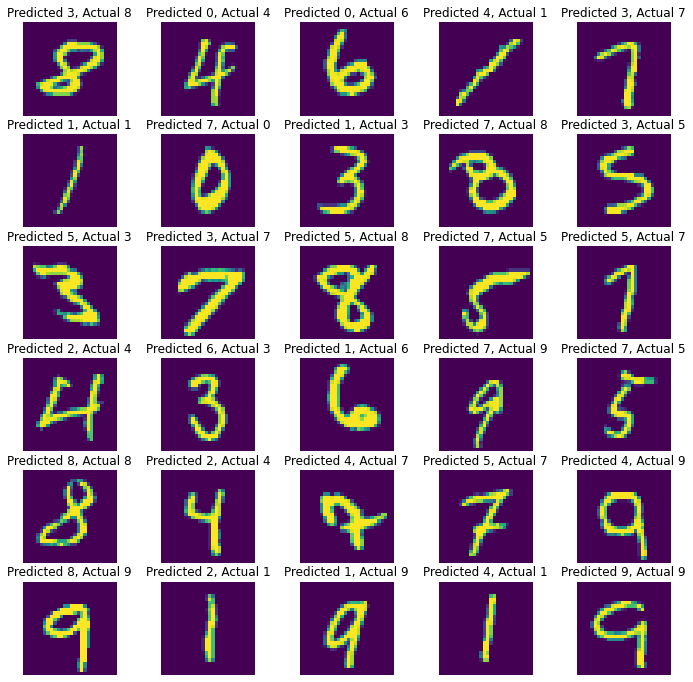

In [37]:
wrong_pred(model2,test_loader,test_data,30,6,5)

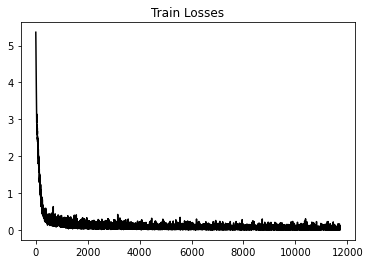

In [28]:
_ = plt.plot(train_losses_image,color = 'black')
_ = plt.title('Train Losses')

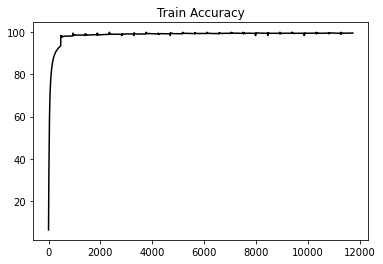

In [29]:
_ = plt.plot(train_acc,color = 'black')
_ = plt.title('Train Accuracy')

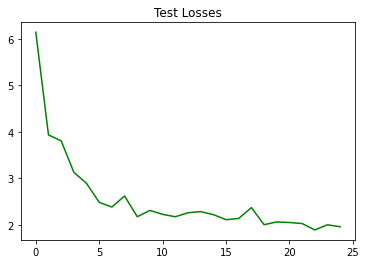

In [30]:
_ = plt.plot(test_losses_image,color = 'green')
_ = plt.title('Test Losses')

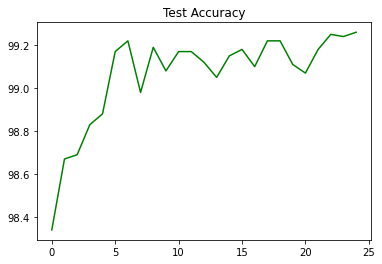

In [31]:
_ = plt.plot(test_acc,color = 'green')
_ = plt.title('Test Accuracy')